In [93]:
# Import modules for data wrangling
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_profiling import ProfileReport
from datetime import datetime

In [46]:
# Read in .csv data to be cleaned
# Change global setting so that all columns will be displayed in dataframes and analyses
# The data file imported in this notebook can be downloaded at https://emp.lbl.gov/sites/default/files/public_datafile.zip
data = pd.read_csv('..\data\external\TTS_LBNL_public_file_07-Sep-2022_all.csv')
pd.set_option('display.max_columns', None)
data.head()

C:\Users\Zachary Brown\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,2,3,14,15,17,19,27,28,30,31,33,34,37,38,39,52,53,55,56,58,59,73,74,75) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,data_provider_1,data_provider_2,system_ID_1,system_ID_2,installation_date,system_size_DC,total_installed_price,rebate_or_grant,customer_segment,expansion_system,...,output_capacity_inverter_1,output_capacity_inverter_2,output_capacity_inverter_3,DC_optimizer,inverter_loading_ratio,dateOfBatteryInstall,battery_manufacturer,battery_model,battery_rated_capacity_kW,battery_rated_capacity_kWh
0,Massachusetts Clean Energy Center,Massachusetts Department of Energy Resources,GBI-JH4-00002,-1,26-Sep-2003,26.4,224000.00,241308.00,COM,0,...,2.5,-1.0,-1.0,0,0.96,-1,-1,-1,-1.0,-1.0
1,Massachusetts Clean Energy Center,Massachusetts Department of Energy Resources,CPV-LG8-00003,-1,17-Apr-2003,2.2,16621.00,9256.50,RES,0,...,2.5,-1.0,-1.0,0,0.88,-1,-1,-1,-1.0,-1.0
2,Massachusetts Clean Energy Center,Massachusetts Department of Energy Resources,CPV-LG8-00004,-1,05-May-2003,2.2,16621.00,9256.50,RES,0,...,2.5,-1.0,-1.0,0,0.88,-1,-1,-1,-1.0,-1.0
3,Massachusetts Clean Energy Center,Massachusetts Department of Energy Resources,CPV-LG8-00005,-1,25-Jun-2003,2.2,16621.00,9256.50,RES,0,...,2.5,-1.0,-1.0,0,0.88,-1,-1,-1,-1.0,-1.0
4,Massachusetts Clean Energy Center,Massachusetts Department of Energy Resources,CPV-LG8-00006,-1,05-May-2003,2.1,16006.95,8835.75,RES,0,...,2.5,-1.0,-1.0,0,0.84,-1,-1,-1,-1.0,-1.0


In [47]:
data.shape

(2362537, 78)

In [48]:
data.columns

Index(['data_provider_1', 'data_provider_2', 'system_ID_1', 'system_ID_2',
       'installation_date', 'system_size_DC', 'total_installed_price',
       'rebate_or_grant', 'customer_segment', 'expansion_system',
       'multiple_phase_system', 'new_construction', 'tracking',
       'ground_mounted', 'zip_code', 'city', 'state',
       'utility_service_territory', 'third_party_owned', 'installer_name',
       'self_installed', 'azimuth_1', 'azimuth_2', 'azimuth_3', 'tilt_1',
       'tilt_2', 'tilt_3', 'module_manufacturer_1', 'module_model_1',
       'module_quantity_1', 'module_manufacturer_2', 'module_model_2',
       'module_quantity_2', 'module_manufacturer_3', 'module_model_3',
       'module_quantity_3', 'additional_modules', 'technology_module_1',
       'technology_module_2', 'technology_module_3', 'BIPV_module_1',
       'BIPV_module_2', 'BIPV_module_3', 'bifacial_module_1',
       'bifacial_module_2', 'bifacial_module_3', 'nameplate_capacity_module_1',
       'nameplate_capaci

In [49]:
data.dtypes

data_provider_1                object
data_provider_2                object
system_ID_1                    object
system_ID_2                    object
installation_date              object
                               ...   
dateOfBatteryInstall           object
battery_manufacturer           object
battery_model                  object
battery_rated_capacity_kW     float64
battery_rated_capacity_kWh    float64
Length: 78, dtype: object

In [50]:
# I only want to analyze residential installations, so I need to check what the values in 'customer_segment' are that represent
# residential vs commercial
print(data['customer_segment'].unique())

['COM' 'RES' 'SCHOOL' 'GOV' 'NON-PROFIT' '-1' 'NON-RES']


In [51]:
# Now I'll subset the data to just residential installations
res_data = data[data['customer_segment'] == 'RES']
res_data.shape

(2262667, 78)

In [57]:
# I'm only interested in the most recent year of data - 2021 - so I'll first check to make sure that there are enough 
# installations to still create a valid model if I pare the data down to only 2021
newest_year = res_data['installation_date'].str[7:11] == '2021'
res_data[newest_year].shape

(276683, 78)

In [62]:
# Great! I still have >200,000 installations to analyze which should be plenty.
# Let's now change the 'installation_date' column to datetime
newest_res_data = res_data[newest_year].copy()
newest_res_data.head()

,data_provider_1,data_provider_2,system_ID_1,system_ID_2,installation_date,system_size_DC,total_installed_price,rebate_or_grant,customer_segment,expansion_system,...,output_capacity_inverter_1,output_capacity_inverter_2,output_capacity_inverter_3,DC_optimizer,inverter_loading_ratio,dateOfBatteryInstall,battery_manufacturer,battery_model,battery_rated_capacity_kW,battery_rated_capacity_kWh
291412,Arizona Public Service,-1,117914,-1,04-Jan-2021,8.450,38648.65,-1.0,RES,0,...,7.616,-1.0,-1.0,1,-1.0,-1,-1,-1,-1.0,-1.0
291413,Arizona Public Service,-1,117915,-1,04-Jan-2021,14.950,99810.72,-1.0,RES,0,...,0.240,-1.0,-1.0,0,-1.0,-1,-1,-1,-1.0,-1.0
291414,Arizona Public Service,-1,117916,-1,04-Jan-2021,21.775,51909.00,-1.0,RES,0,...,0.240,-1.0,-1.0,0,-1.0,-1,-1,-1,-1.0,-1.0
291415,Arizona Public Service,-1,117917,-1,04-Jan-2021,8.520,25866.00,-1.0,RES,0,...,7.616,-1.0,-1.0,1,-1.0,-1,-1,-1,-1.0,-1.0
291416,Arizona Public Service,-1,117918,-1,04-Jan-2021,5.510,15335.28,-1.0,RES,0,...,5.052,-1.0,-1.0,1,-1.0,-1,-1,-1,-1.0,-1.0


In [78]:
# Now I'll convert the 'installation_date' column to datetime
newest_res_data['installation_date'] = pd.to_datetime(newest_res_data['installation_date'], format = "%d/%b/%Y")

In [84]:
newest_res_data.dtypes

data_provider_1                            object
data_provider_2                            object
system_ID_1                                object
system_ID_2                                object
installation_date             datetime64[ns, UTC]
                                     ...         
dateOfBatteryInstall                       object
battery_manufacturer                       object
battery_model                              object
battery_rated_capacity_kW                 float64
battery_rated_capacity_kWh                float64
Length: 78, dtype: object

In [92]:
# Rather than have the model attempt to process each day of the year, it makes more sense to break the date into bins by 
# month
newest_res_data['installation_month'] = newest_res_data['installation_date'].dt.month
newest_res_data['installation_month'].value_counts()

7     26983
12    25174
8     24470
3     24287
11    23935
6     23588
9     22818
10    22507
4     22197
1     21007
5     19941
2     19776
Name: installation_month, dtype: int64

In [85]:
# Now I'll confirm that the monetary columns are correctly detected as floats
newest_res_data[['total_installed_price', 'rebate_or_grant']].dtypes

total_installed_price    float64
rebate_or_grant          float64
dtype: object

In [90]:
# To perform some preliminary checks I'll take a look at the .describe() results for the pared down dataset
newest_res_data.describe(include='all', datetime_is_numeric=True)

,data_provider_1,data_provider_2,system_ID_1,system_ID_2,installation_date,system_size_DC,total_installed_price,rebate_or_grant,customer_segment,expansion_system,...,output_capacity_inverter_2,output_capacity_inverter_3,DC_optimizer,inverter_loading_ratio,dateOfBatteryInstall,battery_manufacturer,battery_model,battery_rated_capacity_kW,battery_rated_capacity_kWh,final_price
count,276683,276683,276683.0,276683,276683,276683.000000,2.766830e+05,276683.000000,276683,276683.000000,...,276683.000000,276683.000000,276683.000000,276683.000000,276683,276672,276672,276683.000000,276683.000000,2.766830e+05
unique,25,6,262337.0,8877,NaN,NaN,NaN,NaN,1,NaN,...,NaN,NaN,NaN,NaN,473,25,48,NaN,NaN,NaN
top,California Public Utilities Commission,-1,-1.0,-1,NaN,NaN,NaN,NaN,RES,NaN,...,NaN,NaN,NaN,NaN,-1,-1,-1,NaN,NaN,NaN
freq,175392,171727,12005.0,168409,NaN,NaN,NaN,NaN,276683,NaN,...,NaN,NaN,NaN,NaN,209495,203150,210645,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,2021-07-06 01:59:44.724757248+00:00,8.397670,2.723398e+04,240.530170,NaN,0.061984,...,-0.907894,-0.995246,0.170488,0.364876,NaN,NaN,NaN,-0.310767,0.507268,2.699345e+04
min,NaN,NaN,NaN,NaN,2021-01-01 00:00:00+00:00,-1.000000,-1.000000e+00,-1.000000,NaN,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,NaN,NaN,NaN,-1.000000,-6.000000,-7.071860e+03
25%,NaN,NaN,NaN,NaN,2021-04-07 00:00:00+00:00,4.760000,1.538610e+04,0.000000,NaN,0.000000,...,-1.000000,-1.000000,0.000000,-1.000000,NaN,NaN,NaN,-1.000000,-1.000000,1.515070e+04
50%,NaN,NaN,NaN,NaN,2021-07-08 00:00:00+00:00,7.000000,2.407048e+04,0.000000,NaN,0.000000,...,-1.000000,-1.000000,0.000000,1.073684,NaN,NaN,NaN,-1.000000,-1.000000,2.384000e+04
75%,NaN,NaN,NaN,NaN,2021-10-05 00:00:00+00:00,9.720000,3.542900e+04,0.000000,NaN,0.000000,...,-1.000000,-1.000000,1.000000,1.233334,NaN,NaN,NaN,-1.000000,-1.000000,3.515467e+04
max,NaN,NaN,NaN,NaN,2021-12-31 00:00:00+00:00,68812.000000,1.721412e+07,216311.000000,NaN,1.000000,...,1501.000000,62.500000,1.000000,1.500000,NaN,NaN,NaN,3647.220000,9482.772000,1.721412e+07


So there are some obvious issues presented from these descriptive statistics:
    'total_installed_price' and 'rebate_or_grant' both show -1 as their lowest value, which is obviously incorrect
    There are 473 unique values for 'date_of_battery_install' which should max out at 365, so something is off there
    

In [87]:
# I will need to calculate the final price by subtracting 'rebate_or_grant' from 'total_installed_price', so any rows with no
# data for 'total_installed_price' should be removed
print(newest_res_data['total_installed_price'].isna().sum())

0


<function matplotlib.pyplot.show(close=None, block=None)>

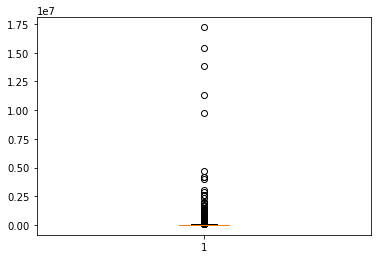

In [102]:
# Now I'll plot a box plogt of 'total_installed_price' to look for outliers and to determine if there is 
# a threshold below which we can safely say the values are erroneous or placeholders
plt.boxplot(newest_res_data['total_installed_price'])
plt.show

In [88]:
# I can go ahead and create the final price column that will be my metric for the model
newest_res_data['final_price'] = newest_res_data['total_installed_price'] - newest_res_data['rebate_or_grant']

In [ ]:
res_data.profile_report()